In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import glob

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X = np.load('/content/drive/My Drive/COVID_XRAY/X.npy')

X = X.reshape((len(X), 512, 512, 1))

y = pd.read_csv('/content/drive/My Drive/COVID_XRAY/y.csv', index_col=0)
y.head()

,Infection Bool
0,False
1,False
2,False
3,False
4,False


In [ ]:
y.describe()

,Infection Bool
count,5745
unique,2
top,False
freq,3573


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from keras import Sequential, Input, Model
from keras.metrics import Recall

In [ ]:
model = Sequential()

model.add(Conv2D(8, 3, input_shape=(512, 512, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(16, 6))
model.add(MaxPooling2D(pool_size=4))
model.add(BatchNormalization())

model.add(Conv2D(20, 12))
model.add(MaxPooling2D(pool_size=8))
model.add(Flatten())

model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 510, 510, 8)       80        
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 255, 255, 8)       0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 255, 255, 8)       32        
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 250, 250, 16)      4624      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 62, 62, 16)        64        
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 51, 51, 20)      

In [ ]:
hist = model.fit(X_train, y_train, epochs=16, validation_data=(X_test, y_test))

Train on 3849 samples, validate on 1896 samples
Epoch 1/16
3849/3849 [==============================] - 29s 7ms/step - loss: 0.5141 - val_loss: 0.5358
Epoch 2/16
3849/3849 [==============================] - 28s 7ms/step - loss: 0.3672 - val_loss: 0.2887
Epoch 3/16
3849/3849 [==============================] - 28s 7ms/step - loss: 0.3039 - val_loss: 0.2618
Epoch 4/16
3849/3849 [==============================] - 28s 7ms/step - loss: 0.2372 - val_loss: 0.1546
Epoch 5/16
3849/3849 [==============================] - 28s 7ms/step - loss: 0.2134 - val_loss: 0.1634
Epoch 6/16
3849/3849 [==============================] - 28s 7ms/step - loss: 0.1622 - val_loss: 0.1443
Epoch 7/16
3849/3849 [==============================] - 28s 7ms/step - loss: 0.1051 - val_loss: 0.1187
Epoch 8/16
3849/3849 [==============================] - 28s 7ms/step - loss: 0.0853 - val_loss: 0.0955
Epoch 9/16
3849/3849 [==============================] - 28s 7ms/step - loss: 0.0578 - val_loss: 0.1164
Epoch 10/16
3849/3849 [==

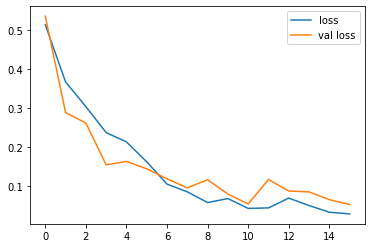

In [ ]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()

In [ ]:
y_hat = model.predict(X_test)

In [ ]:
y_hat_bool = y_hat > 0.5

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_hat_bool, y_test).ravel()

precision = tp/(tp + fp)
recall = tp/(tp + fn)
fpr = fp/(fp + tn)

print(precision)
print(recall)
print(fpr)

0.9678714859437751
0.9890560875512996
0.020600858369098713


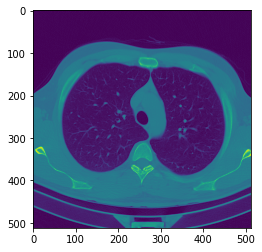

In [ ]:
plt.imshow(X[0].reshape((512, 512)))

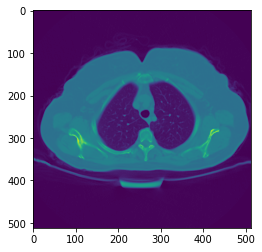

In [ ]:
plt.imshow(X[57].reshape((512, 512)))

Transfer learning

In [ ]:
from keras.models import load_model
from keras.models import model_from_json
import json

with open('/content/drive/My Drive/COVID_XRAY/model_in_json.json','r') as f:
    model_json = json.load(f)

model_pneumonia = model_from_json(model_json)
model_pneumonia.load_weights('/content/drive/My Drive/COVID_XRAY/model_weights.h5')

In [ ]:
model_pneumonia.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [ ]:
model_pneumonia.layers[0].trainable = False
model_pneumonia.layers[1].trainable = False
model_pneumonia.layers[2].trainable = False
model_pneumonia.layers[3].trainable = False

In [ ]:
input = Input(shape=(512, 512, 1))

hidden1 = Conv2D(3, 5)(input)
hidden2 = MaxPooling2D(pool_size=2)(hidden1)
hidden3 = BatchNormalization()(hidden2)

pneumonia1 = model_pneumonia.layers[0](hidden3)
pneumonia2 = model_pneumonia.layers[1](pneumonia1)
pneumonia3 = model_pneumonia.layers[2](pneumonia2)
pneumonia4 = model_pneumonia.layers[3](pneumonia3)
pneumonia5 = BatchNormalization()(pneumonia4)

hidden4 = Conv2D(16, 6)(pneumonia5)
hidden5 = MaxPooling2D(pool_size=4)(hidden4)
hidden6 = BatchNormalization()(hidden5)

hidden7 = Conv2D(32, 6)(hidden6)
hidden8 = MaxPooling2D(pool_size=4)(hidden7)
hidden8b = BatchNormalization()(hidden8)

hidden9 = Flatten()(hidden8b)

hidden10 = Dropout(0.2)(hidden9)

hidden11 = Dense(16, activation='relu')(hidden10)

output = Dense(1, activation='sigmoid')(hidden11)

model2 = Model(inputs=input, outputs=output)

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy')
model2.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 508, 508, 3)       78        
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 254, 254, 3)       0         
_________________________________________________________________
batch_normalization_98 (Batc (None, 254, 254, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  184

In [ ]:
hist = model2.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Train on 3849 samples, validate on 1896 samples
Epoch 1/20
3849/3849 [==============================] - 27s 7ms/step - loss: 0.4485 - val_loss: 1.7059
Epoch 2/20
3849/3849 [==============================] - 26s 7ms/step - loss: 0.2815 - val_loss: 0.4475
Epoch 3/20
3849/3849 [==============================] - 26s 7ms/step - loss: 0.1689 - val_loss: 0.3204
Epoch 4/20
3849/3849 [==============================] - 26s 7ms/step - loss: 0.1416 - val_loss: 0.4619
Epoch 5/20
3849/3849 [==============================] - 26s 7ms/step - loss: 0.0960 - val_loss: 0.2334
Epoch 6/20
3849/3849 [==============================] - 26s 7ms/step - loss: 0.0863 - val_loss: 0.0955
Epoch 7/20
3849/3849 [==============================] - 26s 7ms/step - loss: 0.0492 - val_loss: 0.1168
Epoch 8/20
3849/3849 [==============================] - 26s 7ms/step - loss: 0.0567 - val_loss: 0.3454
Epoch 9/20
3849/3849 [==============================] - 26s 7ms/step - loss: 0.0521 - val_loss: 0.0758
Epoch 10/20
3849/3849 [==

KeyboardInterrupt: ignored

Precision 0.9625167336010709
Accuracy 0.9773206751054853
Recall 0.9795640326975477
FPR 0.024096385542168676


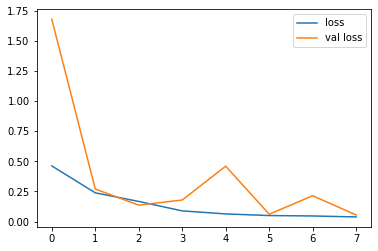

In [ ]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()

y_hat = model2.predict(X_test)
y_hat_bool = y_hat > 0.5

tn, fp, fn, tp = confusion_matrix(y_hat_bool, y_test).ravel()

accuracy = (tp + tn)/(tn + fp + fn + tp)
precision = tp/(tp + fp)
recall = tp/(tp + fn)
fpr = fp/(fp + tn)


print("Precision " + str(precision))
print("Accuracy " + str(accuracy))
print("Recall " + str(recall))
print("FPR " + str(fpr))

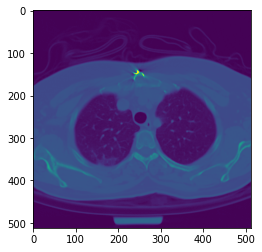

False True


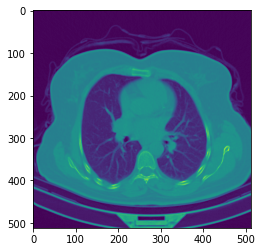

True False


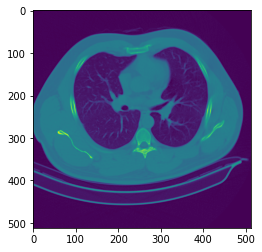

True False


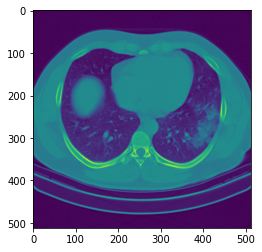

False True


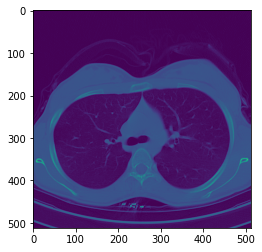

True False


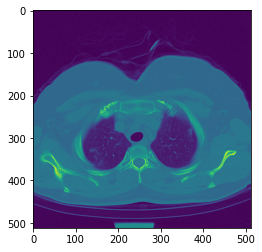

False True


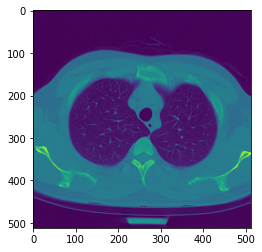

True False


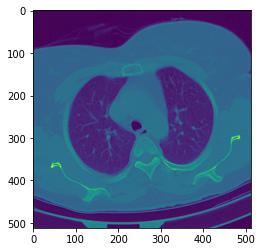

True False


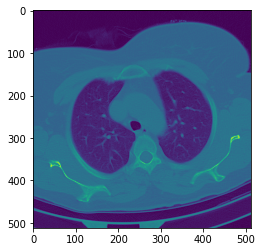

True False


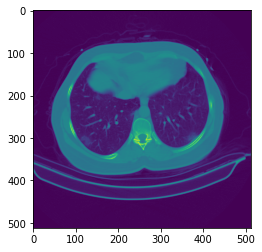

False True


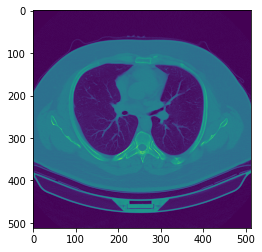

True False


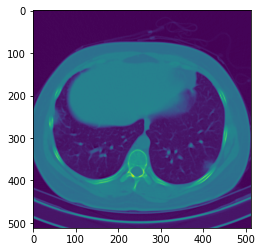

False True


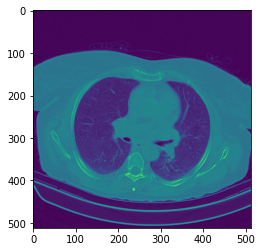

True False


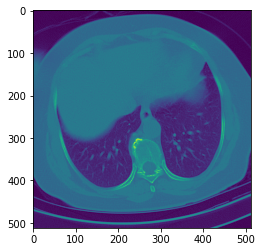

True False


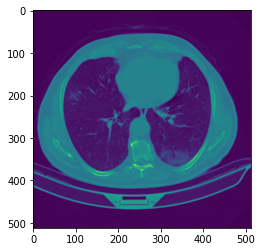

False True


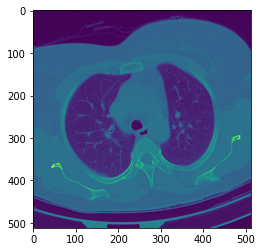

True False


KeyboardInterrupt: ignored

In [ ]:
y_t = y_test['Infection Bool'].to_list()

for i, img in enumerate(X_test):
  pred = model2.predict(img.reshape((1, 512, 512, 1)))

  if ((pred[0][0] > 0.5) ^ (y_t[i])):
    plt.imshow(img.reshape((512, 512)))
    plt.show()
    print(pred[0][0] > 0.5, y_t[i])
